In [1]:
import os 
import glob
import pandas as pd

import cv2
from torch.utils.data import Dataset
#Img Augment
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from torchvision import transforms as T
import matplotlib.patches as patches

from dataload import xml_to_csv,PetData

## Model Workflow
How R-CNN works can be summarized as follows:

1. *Pre-train a CNN* network on image classification tasks; for example, VGG or ResNet trained on ImageNet dataset. The classification task involves N classes.
    NOTE: You can find a pre-trained AlexNet in Caffe Model Zoo. I don’t think you can find it in Tensorflow, but Tensorflow-slim model library provides pre-trained ResNet, VGG, and others.

2. Propose category-independent regions of interest by selective search (~2k candidates per image). Those regions may contain target objects and they are of different sizes.
3. Region candidates are warped to have a fixed size as required by CNN.
4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.
5. Given every image region, one forward propagation through the CNN generates a feature vector. This feature vector is then consumed by a binary SVM trained for each class independently.
6. The positive samples are proposed regions with IoU (intersection over union) overlap threshold >= 0.3, and negative samples are irrelevant others.
To reduce the localization errors, a regression model is trained to correct the predicted detection window on bounding box correction offset using CNN features.

## 1. Pretrain a CNN network on image classification

In [2]:
import torch
from torchvision import models
mobilenet = models.mobilenet_v2(pretrained=True)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(mobilenet)}')


Num of parameters: 3504872


In [3]:
##Loading data
root_path="D:/Dataset/Pet_Data/"
img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

df=xml_to_csv(annots,img_path)
df.head()

BATCH_SIZE = 20
train_ds = PetData(df, train=True)


def collate_fn(batch):
    return tuple(zip(*batch))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

## 2. Selective Search from [AlpacaDB](https://github.com/AlpacaDB/selectivesearch)
Explanation to be added

In [4]:
from utills import ssearch,misc

In [5]:
BATCH_SIZE = 5
train_ds = PetData(df, train=True,tensor_return=False)
def collate_fn(batch):
    return tuple(zip(*batch))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=True)

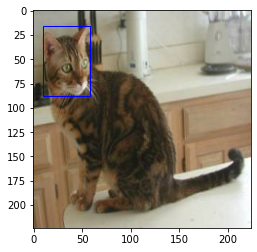

In [6]:
one_batch=next(iter(train_dl))
misc.disp_batch(one_batch,True)

In [39]:
img_lbl, regions = ssearch.selective_search(train_ds[0][0].numpy().transpose(1,2,0), scale=224, sigma=0.9, min_size=20)
len(regions)

122

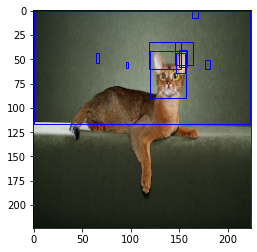

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(img_lbl[:,:,0:3]*0.5+0.5)
for i in regions[0:10]:
    rect=i['rect']
    xy=rect[0],rect[1]
    width=rect[2]
    height=rect[3]
    
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False ) )
plt.show()

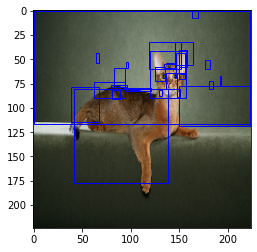

In [137]:
fig, ax = plt.subplots()
ax.imshow(img_lbl[:,:,0:3]*0.5+0.5)
for i in regions[0:32]:
    rect=i['rect']
    xy=rect[0],rect[1]
    width=rect[2]
    height=rect[3]
    
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False ) )
plt.show()

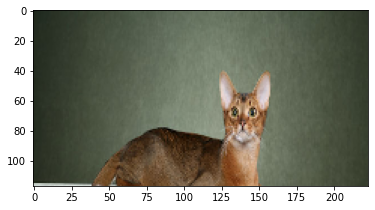

In [91]:
plt.imshow((train_ds[0][0][:,y1:y2,x1:x2]*0.5+0.5).permute(1,2,0).numpy())

## 3. Region candidates are warped to have a fixed size as required by CNN.

In [148]:
import numpy as np
idx=0
data=train_ds[idx][0]
img_lbl, regions = ssearch.selective_search(data.numpy().transpose(1,2,0), scale=224, sigma=0.9, min_size=10)
regions=regions[0:32] #We limit the regions to 32 regions for hardware
canvas=torch.zeros((32,3,224,224))
for idx,region in enumerate(regions):
    x1=region['rect'][0]
    y1=region['rect'][1]
    x2=region['rect'][2]+x1+1
    y2=region['rect'][3]+y1+1
    canvas[idx,:,:,:]=nn.Upsample((224,224))(train_ds[0][0][:,y1:y2,x1:x2].unsqueeze(0))


In [149]:
import torch.nn as nn
from torchvision.utils import make_grid

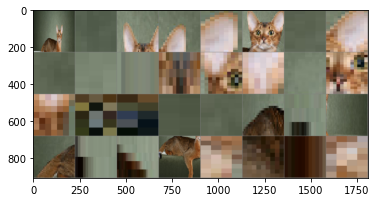

In [150]:
grid = make_grid(canvas, nrow=8)
plt.imshow(grid.permute(1, 2, 0)*0.5+0.5)

## 4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.